In [ ]:
!pip -q install kagglehub

import os, glob
import kagglehub

WORK_DIR = "/content/working"
os.makedirs(WORK_DIR, exist_ok=True)

DATA_ROOT = kagglehub.dataset_download("truthisneverlinear/childrens-dental-panoramic-radiographs-dataset")
print("DATA_ROOT:", DATA_ROOT)

# Try to auto-locate the expected subfolders
wanted = ["Dental_dataset","Adult tooth segmentation dataset","Panoramic radiography database"]
def has_all(p):
    p = p.replace("\\","/").lower()
    return all(w.lower() in p for w in wanted)

cand_img, cand_msk = [], []
for root, dirs, files in os.walk(DATA_ROOT):
    if has_all(root):
        base = os.path.basename(root).lower()
        if base in {"image","images"}: cand_img.append(root)
        if base in {"mask","masks"}:  cand_msk.append(root)

if not cand_img or not cand_msk:  # fallback: search anywhere
    for root, _, _ in os.walk(DATA_ROOT):
        base = os.path.basename(root).lower()
        if base in {"image","images"} and root not in cand_img: cand_img.append(root)
        if base in {"mask","masks"}  and root not in cand_msk:  cand_msk.append(root)

IMAGES_DIR = sorted(cand_img, key=len)[-1]
MASKS_DIR  = sorted(cand_msk, key=len)[-1]
print("IMAGES_DIR:", IMAGES_DIR)
print("MASKS_DIR :", MASKS_DIR)

import tensorflow as tf
print("TF:", tf.__version__)


100%|██████████| 1.55G/1.55G [01:11<00:00, 23.3MB/s]

Extracting files...


DATA_ROOT: /root/.cache/kagglehub/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset/versions/1
IMAGES_DIR: /root/.cache/kagglehub/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset/versions/1/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database/images
MASKS_DIR : /root/.cache/kagglehub/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset/versions/1/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database/mask
TF: 2.19.0


In [ ]:
import tensorflow as tf, os, glob

IMG_SIZE = (224, 224)

def load_pair(img_path, mask_path):
    img  = tf.io.read_file(img_path)
    msk  = tf.io.read_file(mask_path)

    img  = tf.image.decode_image(img,  channels=1, expand_animations=False)
    msk  = tf.image.decode_image(msk,  channels=1, expand_animations=False)

    img  = tf.image.resize(img, IMG_SIZE)
    msk  = tf.image.resize(msk, IMG_SIZE, method='nearest')

    img  = tf.cast(img, tf.float32) / 255.0
    msk  = tf.cast(msk > 127, tf.float32)   # binarize
    return img, msk

images = sorted(glob.glob(os.path.join(IMAGES_DIR, "*")))
masks  = sorted(glob.glob(os.path.join(MASKS_DIR,  "*")))
assert len(images) == len(masks) and len(images) > 0, "Make sure images & masks counts match."

ds = tf.data.Dataset.from_tensor_slices((images, masks)).map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)

N = len(images)
split = int(0.8 * N)
BATCH = 8

train_ds = ds.take(split).shuffle(512).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = ds.skip(split).batch(BATCH).prefetch(tf.data.AUTOTUNE)

N, split


(598, 478)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ---------- helpers ----------
def apply_activation(x, act, leaky_alpha=0.2):
    if callable(act):
        return layers.Activation(act)(x)
    if isinstance(act, str) and act.lower() == "leakyrelu":
        return layers.LeakyReLU(alpha=leaky_alpha)(x)
    return layers.Activation(act)(x)

def conv_block(x, filters, kernel=3, padding='same', strides=1, activation=tf.nn.relu, scope=None):
    # Use unique names if a scope is provided; otherwise let Keras auto-name.
    name1 = None if scope is None else f"{scope}_conv1"
    bn1   = None if scope is None else f"{scope}_bn1"
    name2 = None if scope is None else f"{scope}_conv2"
    bn2   = None if scope is None else f"{scope}_bn2"

    x = layers.Conv2D(filters, kernel, strides=strides, padding=padding, use_bias=False, name=name1)(x)
    x = layers.BatchNormalization(name=bn1)(x)
    x = apply_activation(x, activation)

    x = layers.Conv2D(filters, kernel, strides=1, padding=padding, use_bias=False, name=name2)(x)
    x = layers.BatchNormalization(name=bn2)(x)
    x = apply_activation(x, activation)
    return x

# ---------- encoder / decoder with UNIQUE scopes ----------
def encoder(x, filters, *, padding='same', strides=1, kernel=3, activation=tf.nn.leaky_relu, scope=None):
    x = conv_block(x, filters, kernel=kernel, padding=padding, strides=strides, activation=activation, scope=scope)
    skip = x
    x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same', name=None if scope is None else f"{scope}_pool")(x)
    return x, skip

def upsample_concat(x, skip, filters, scope=None):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same', use_bias=False,
                               name=None if scope is None else f"{scope}_up")(x)
    x = layers.Concatenate(name=None if scope is None else f"{scope}_concat")([x, skip])
    return x

def decoder(x, filters, skip, *, padding='same', strides=1, kernel=3, activation=tf.nn.relu, scope=None):
    x = upsample_concat(x, skip, filters, scope=scope)
    x = conv_block(x, filters, kernel=kernel, padding=padding, strides=1, activation=activation, scope=scope)
    return x

# ---------- generator (U-Net) with unique enc*/dec* scopes ----------
def build_generator(input_shape=(224,224,1), base=32, kernel=3, leaky_alpha=0.2):
    inp = layers.Input(shape=input_shape)
    leaky = lambda t: tf.nn.leaky_relu(t, alpha=leaky_alpha)
    relu  = tf.nn.relu

    x1, s1 = encoder(inp, base*1,  kernel=kernel, activation=leaky, scope='enc1')
    x2, s2 = encoder(x1, base*2,   kernel=kernel, activation=leaky, scope='enc2')
    x3, s3 = encoder(x2, base*4,   kernel=kernel, activation=leaky, scope='enc3')
    x4, s4 = encoder(x3, base*8,   kernel=kernel, activation=leaky, scope='enc4')
    x5, s5 = encoder(x4, base*16,  kernel=kernel, activation=leaky, scope='enc5')

    d1 = decoder(x5, base*16, s5, kernel=kernel, activation=relu, scope='dec1')
    d2 = decoder(d1, base*8,  s4, kernel=kernel, activation=relu, scope='dec2')
    d3 = decoder(d2, base*4,  s3, kernel=kernel, activation=relu, scope='dec3')
    d4 = decoder(d3, base*2,  s2, kernel=kernel, activation=relu, scope='dec4')
    d5 = decoder(d4, base*1,  s1, kernel=kernel, activation=relu, scope='dec5')

    out = layers.Conv2DTranspose(1, kernel, strides=1, padding='same', activation='sigmoid', name='gen_out')(d5)
    return models.Model(inp, out, name="generator")

# Rebuild models
G = build_generator(input_shape=(224,224,1), base=32)
G.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 224, 224,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn1            │ (None, 224, 224,  │        128 │ enc1_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ enc1_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 224, 224,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn2            │ (None, 224, 224,  │        128 │ enc1_conv2[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ enc1_bn2[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_pool           │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 112, 112,  │     18,432 │ enc1_pool[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn1            │ (None, 112, 112,  │        256 │ enc2_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ enc2_bn1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 112, 112,  │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn2            │ (None, 112, 112,  │        256 │ enc2_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ enc2_bn2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_pool           │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_conv1 (Conv2D) │ (None, 56, 56,    │     73,728 │ enc2_pool[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_bn1            │ (None, 56, 56,    │        512 │ enc3_conv1[0][0]

 Total params: 15,898,689 (60.65 MB)

 Trainable params: 15,890,753 (60.62 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [ ]:
# NEXT CELL — build PatchGAN discriminator with unique layer names and summarize

import tensorflow as tf
from tensorflow.keras import layers, models

def build_discriminator(input_shape=(224, 224, 1), name="discriminator"):
    img_in = layers.Input(shape=input_shape, name=f"{name}_img_in")
    seg_in = layers.Input(shape=input_shape, name=f"{name}_seg_in")
    x = layers.Concatenate(name=f"{name}_concat")([img_in, seg_in])  # (H,W,2)

    def d_block(x, f, k=4, s=2, bn=True, scope=None):
        x = layers.Conv2D(f, k, strides=s, padding='same', use_bias=not bn,
                          name=None if scope is None else f"{scope}_conv")(x)
        if bn:
            x = layers.BatchNormalization(name=None if scope is None else f"{scope}_bn")(x)
        x = layers.LeakyReLU(0.2, name=None if scope is None else f"{scope}_lrelu")(x)
        return x

    x = d_block(x,  64, 4, 2, bn=False, scope=f"{name}_b1")
    x = d_block(x, 128, 4, 2, bn=True,  scope=f"{name}_b2")
    x = d_block(x, 256, 4, 2, bn=True,  scope=f"{name}_b3")
    x = d_block(x, 512, 4, 1, bn=True,  scope=f"{name}_b4")

    out = layers.Conv2D(1, 4, strides=1, padding='same', activation='sigmoid',
                        name=f"{name}_patch_out")(x)

    return models.Model([img_in, seg_in], out, name=name)

# Instantiate and summarize
D = build_discriminator(input_shape=(224, 224, 1), name="discriminator")
D.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ discriminator_img_… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_seg_… │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_conc… │ (None, 224, 224,  │          0 │ discriminator_im… │
│ (Concatenate)       │ 2)                │            │ discriminator_se… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b1_c… │ (None, 112, 112,  │      2,112 │ discriminator_co… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b1_l… │ (None, 112, 112,  │          0 │ discriminator_b1… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b2_c… │ (None, 56, 56,    │    131,072 │ discriminator_b1… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b2_bn │ (None, 56, 56,    │        512 │ discriminator_b2… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b2_l… │ (None, 56, 56,    │          0 │ discriminator_b2… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b3_c… │ (None, 28, 28,    │    524,288 │ discriminator_b2… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b3_bn │ (None, 28, 28,    │      1,024 │ discriminator_b3… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b3_l… │ (None, 28, 28,    │          0 │ discriminator_b3… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b4_c… │ (None, 28, 28,    │  2,097,152 │ discriminator_b3… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b4_bn │ (None, 28, 28,    │      2,048 │ discriminator_b4… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_b4_l… │ (None, 28, 28,    │          0 │ discriminator_b4… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_patc… │ (None, 28, 28, 1) │      8,193 │ discriminator_b4… │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,766,401 (10.55 MB)

 Trainable params: 2,764,609 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# NEXT CELL — losses, metrics, and optimizers for GAN training

import tensorflow as tf

# --- segmentation losses/metrics ---
bce = tf.keras.losses.BinaryCrossentropy()

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true * y_pred)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# --- adversarial loss (PatchGAN) ---
adv_loss_fn = tf.keras.losses.BinaryCrossentropy()

# --- weights for the composite generator loss ---
LAMBDA_SEG = 100.0   # pixel-wise loss weight (BCE + Dice)
LAMBDA_ADV = 1.0     # adversarial loss weight

# --- optimizers ---
G_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
D_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

print("Losses/metrics ready. LAMBDA_SEG =", LAMBDA_SEG, "LAMBDA_ADV =", LAMBDA_ADV)


Losses/metrics ready. LAMBDA_SEG = 100.0 LAMBDA_ADV = 1.0


In [ ]:
import tensorflow as tf

@tf.function
def train_step_gan(G, D, imgs, gt_masks):
    with tf.GradientTape(persistent=True) as tape:
        pred_masks = G(imgs, training=True)
        real_logits = D([imgs, gt_masks], training=True)
        fake_logits = D([imgs, pred_masks], training=True)
        d_loss_real = adv_loss_fn(tf.ones_like(real_logits), real_logits)
        d_loss_fake = adv_loss_fn(tf.zeros_like(fake_logits), fake_logits)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        g_adv = adv_loss_fn(tf.ones_like(fake_logits), fake_logits)
        g_seg = bce(gt_masks, pred_masks) + dice_loss(gt_masks, pred_masks)
        g_loss = LAMBDA_ADV * g_adv + LAMBDA_SEG * g_seg
    d_grads = tape.gradient(d_loss, D.trainable_variables)
    D_opt.apply_gradients(zip(d_grads, D.trainable_variables))
    g_grads = tape.gradient(g_loss, G.trainable_variables)
    G_opt.apply_gradients(zip(g_grads, G.trainable_variables))
    dsc = dice_coef(gt_masks, pred_masks)
    return d_loss, g_loss, g_adv, g_seg, dsc


In [ ]:
from tqdm import tqdm
import os
import tensorflow as tf

EPOCHS_GAN = 20

for epoch in range(1, EPOCHS_GAN + 1):
    pbar = tqdm(train_ds, desc=f"[GAN] Epoch {epoch}/{EPOCHS_GAN}", leave=False)
    for imgs, gt in pbar:
        d_loss, g_loss, g_adv, g_seg, dsc = train_step_gan(G, D, imgs, gt)
        pbar.set_postfix(d=float(d_loss.numpy()), g=float(g_loss.numpy()), dice=float(dsc.numpy()))
    vd = []
    for vi, vg in val_ds.take(10):
        pr = G(vi, training=False)
        vd.append(dice_coef(vg, pr).numpy())
    print(f"Epoch {epoch}: val_dice={float(sum(vd)/len(vd)):.4f}")

G.save_weights(os.path.join(WORK_DIR, "gan_stage_generator.weights.h5"))
D.save_weights(os.path.join(WORK_DIR, "gan_stage_discriminator.weights.h5"))


Epoch 1: val_dice=0.1777


Epoch 2: val_dice=0.1579


Epoch 3: val_dice=0.1119


Epoch 4: val_dice=0.0680


Epoch 5: val_dice=0.0542


Epoch 6: val_dice=0.1657


Epoch 7: val_dice=0.3538


Epoch 8: val_dice=0.6995


Epoch 9: val_dice=0.7928


Epoch 10: val_dice=0.8579


Epoch 11: val_dice=0.8510


Epoch 12: val_dice=0.8883


Epoch 13: val_dice=0.8909


Epoch 14: val_dice=0.8981


Epoch 15: val_dice=0.9009


Epoch 16: val_dice=0.8995


Epoch 17: val_dice=0.8813


Epoch 18: val_dice=0.9055


Epoch 19: val_dice=0.9078


Epoch 20: val_dice=0.9096


In [ ]:
# CELL A — search thresholds to maximize Dice/IoU on validation set

import numpy as np
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    inter = tf.reduce_sum(y_true * y_pred)
    return (2.*inter + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou(y_true, y_pred, smooth=1.0):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def eval_ds(model, dataset, thresh, max_batches=None):
    dices, ious = [], []
    n = 0
    for imgs, gts in dataset:
        preds = model.predict(imgs, verbose=0)
        preds = (preds > thresh).astype(np.float32)
        b = preds.shape[0]
        for i in range(b):
            dices.append(float(dice_coef(gts[i], preds[i]).numpy()))
            ious.append(float(iou(gts[i], preds[i]).numpy()))
        n += 1
        if max_batches and n >= max_batches:
            break
    return float(np.mean(dices)), float(np.mean(ious))

THRS = np.linspace(0.2, 0.8, 25)
rows = []
for t in THRS:
    d, j = eval_ds(G, val_ds, thresh=float(t), max_batches=16)
    rows.append((float(t), d, j))

rows_sorted_dice = sorted(rows, key=lambda r: r[1], reverse=True)
rows_sorted_iou  = sorted(rows, key=lambda r: r[2], reverse=True)

BEST_T_DICE, BEST_DICE, _ = rows_sorted_dice[0]
BEST_T_IOU,  _, BEST_IOU  = rows_sorted_iou[0]

print("Top-5 by Dice:")
for t,d,j in rows_sorted_dice[:5]:
    print(f" t={t:.3f}  Dice={d:.4f}  IoU={j:.4f}")

print("\nTop-5 by IoU:")
for t,d,j in rows_sorted_iou[:5]:
    print(f" t={t:.3f}  Dice={d:.4f}  IoU={j:.4f}")

print(f"\nBest Dice at t={BEST_T_DICE:.3f}: {BEST_DICE:.4f}")
print(f"Best IoU  at t={BEST_T_IOU:.3f}: {BEST_IOU:.4f}")


Top-5 by Dice:
 t=0.375  Dice=0.9099  IoU=0.8394
 t=0.400  Dice=0.9099  IoU=0.8395
 t=0.350  Dice=0.9099  IoU=0.8393
 t=0.325  Dice=0.9098  IoU=0.8392
 t=0.425  Dice=0.9098  IoU=0.8393

Top-5 by IoU:
 t=0.400  Dice=0.9099  IoU=0.8395
 t=0.375  Dice=0.9099  IoU=0.8394
 t=0.350  Dice=0.9099  IoU=0.8393
 t=0.425  Dice=0.9098  IoU=0.8393
 t=0.450  Dice=0.9097  IoU=0.8393

Best Dice at t=0.375: 0.9099
Best IoU  at t=0.400: 0.8395


Top-5 by Dice:
 t=0.400  close=0  min_obj=50  min_hole=32  Dice=0.9093  IoU=0.8403
 t=0.440  close=0  min_obj=50  min_hole=32  Dice=0.9093  IoU=0.8403
 t=0.380  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8403
 t=0.420  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8402
 t=0.460  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8402

Top-5 by IoU:
 t=0.400  close=0  min_obj=50  min_hole=32  Dice=0.9093  IoU=0.8403
 t=0.440  close=0  min_obj=50  min_hole=32  Dice=0.9093  IoU=0.8403
 t=0.380  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8403
 t=0.420  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8402
 t=0.460  close=0  min_obj=50  min_hole=32  Dice=0.9092  IoU=0.8402

Best-by-Dice → t=0.400, closing=0, min_obj=50, min_hole=32, Dice=0.9093
Best-by-IoU  → t=0.400, closing=0, min_obj=50, min_hole=32, IoU=0.8403


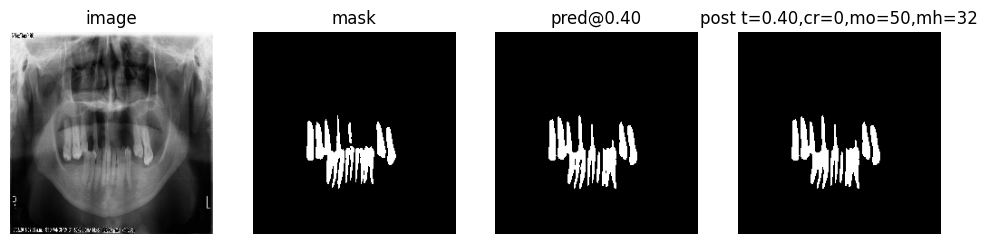

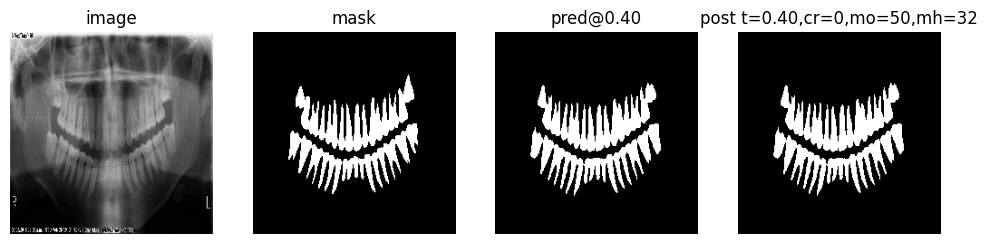

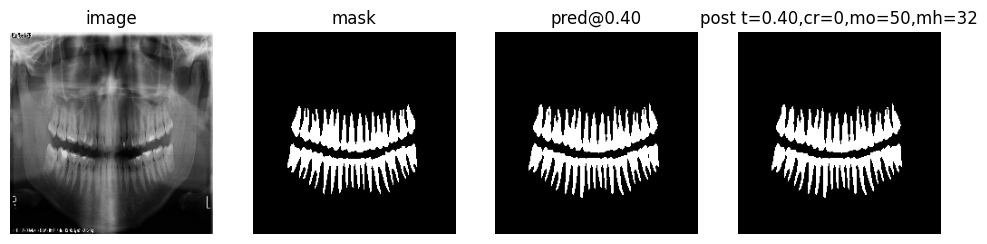

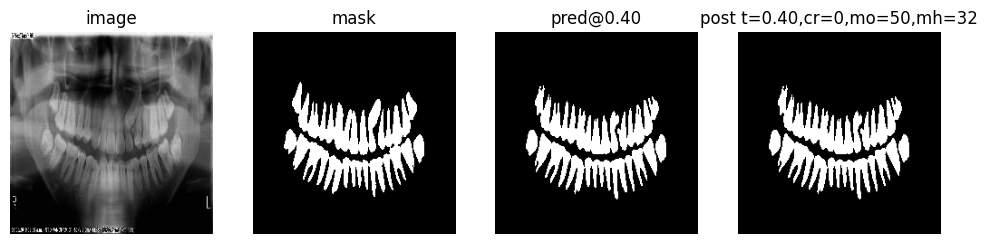

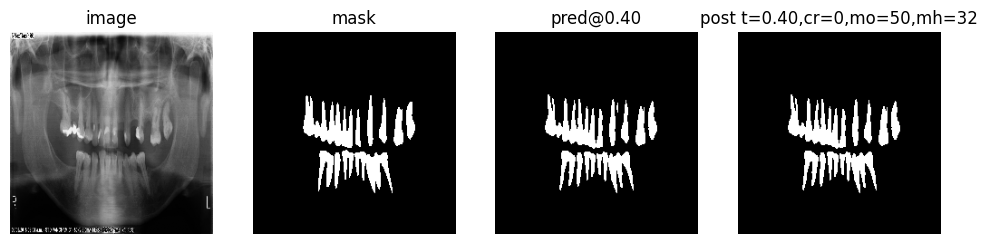

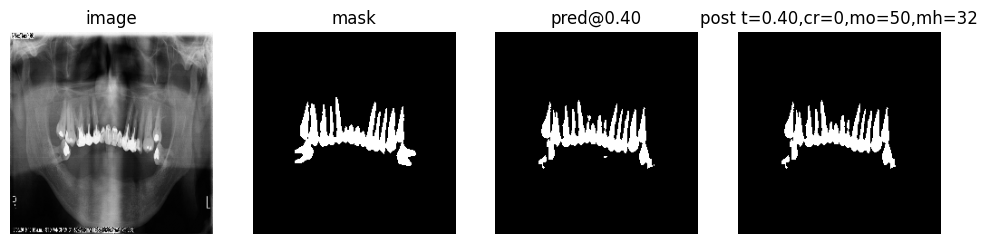

In [ ]:
# GRID SEARCH: optimize threshold + post-processing to maximize Dice/IoU (fast)

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, disk

# --- ensure cached arrays exist (rebuild a small slice if missing) ---
try:
    _ = preds_np, gts_np, imgs_np
except NameError:
    import tensorflow as tf
    MAX_VAL_IMAGES = 64
    BATCH_PRED = 16
    imgs_list, gts_list, count = [], [], 0
    for imgs, gts in val_ds:
        imgs_list.append(imgs.numpy()); gts_list.append(gts.numpy())
        count += imgs.shape[0]
        if count >= MAX_VAL_IMAGES: break
    imgs_np = np.concatenate(imgs_list, 0)[:MAX_VAL_IMAGES]
    gts_np  = np.concatenate(gts_list,  0)[:MAX_VAL_IMAGES]
    preds_np = G.predict(imgs_np, batch_size=BATCH_PRED, verbose=0)

def _to_2d_bool(x):
    m = np.asarray(x)
    if m.ndim == 3 and m.shape[-1] == 1: m = m[..., 0]
    elif m.ndim > 2: m = np.squeeze(m)
    if m.ndim != 2: raise ValueError(f"Expected 2D after squeeze, got {m.shape}")
    return m.astype(bool)

def postprocess_bin(mask_bin, min_obj=200, min_hole=64, closing_radius=2):
    m = _to_2d_bool(mask_bin)
    if closing_radius > 0:
        m = binary_closing(m, disk(int(closing_radius)))
    if min_obj > 0:
        m = remove_small_objects(m, min_size=int(min_obj))
    if min_hole > 0:
        m = remove_small_holes(m, area_threshold=int(min_hole))
    return m.astype(np.float32)[..., None]

def _flatten01(x):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 4 and x.shape[-1] == 1: x = x[..., 0]
    return x.reshape(x.shape[0], -1)

def dice_iou_batch(preds_bin, gts, smooth=1.0):
    pb = _flatten01(preds_bin); g = _flatten01(gts)
    inter = (pb * g).sum(1); sum_p = pb.sum(1); sum_g = g.sum(1)
    dice = (2.0*inter + smooth) / (sum_p + sum_g + smooth)
    union = sum_p + sum_g - inter
    iou  = (inter + smooth) / (union + smooth)
    return float(dice.mean()), float(iou.mean())

# --- search space (keep small for speed; tweak if needed) ---
THRESHOLDS = np.linspace(0.34, 0.50, 9)   # narrow band around your current 0.38
CLOSE_RS   = [0, 1, 2]                    # 0 preserves sharp tips
MIN_OBJS   = [50, 100, 200]               # too big will eat thin teeth
MIN_HOLES  = [32, 64, 128]

# --- run search ---
rows = []
for t in THRESHOLDS:
    pb = (preds_np >= float(t)).astype(np.float32)  # compute once per threshold
    for cr in CLOSE_RS:
        for mo in MIN_OBJS:
            for mh in MIN_HOLES:
                pp = np.stack([postprocess_bin(pb[i], mo, mh, cr) for i in range(pb.shape[0])], 0)
                d, j = dice_iou_batch(pp, gts_np)
                rows.append((float(t), cr, mo, mh, d, j))

rows_d = sorted(rows, key=lambda r: r[4], reverse=True)
rows_j = sorted(rows, key=lambda r: r[5], reverse=True)

BEST_T_DICE, BEST_CR_D, BEST_MO_D, BEST_MH_D, BEST_DICE, _ = rows_d[0]
BEST_T_IOU,  BEST_CR_J, BEST_MO_J, BEST_MH_J, _, BEST_IOU  = rows_j[0]

print("Top-5 by Dice:")
for r in rows_d[:5]:
    print(f" t={r[0]:.3f}  close={r[1]}  min_obj={r[2]}  min_hole={r[3]}  Dice={r[4]:.4f}  IoU={r[5]:.4f}")

print("\nTop-5 by IoU:")
for r in rows_j[:5]:
    print(f" t={r[0]:.3f}  close={r[1]}  min_obj={r[2]}  min_hole={r[3]}  Dice={r[4]:.4f}  IoU={r[5]:.4f}")

print(f"\nBest-by-Dice → t={BEST_T_DICE:.3f}, closing={BEST_CR_D}, min_obj={BEST_MO_D}, min_hole={BEST_MH_D}, Dice={BEST_DICE:.4f}")
print(f"Best-by-IoU  → t={BEST_T_IOU:.3f}, closing={BEST_CR_J}, min_obj={BEST_MO_J}, min_hole={BEST_MH_J}, IoU={BEST_IOU:.4f}")

# --- visualize the best-by-Dice setting on a few samples ---
USE_T, CR, MO, MH = BEST_T_DICE, BEST_CR_D, BEST_MO_D, BEST_MH_D
preds_bin = (preds_np >= USE_T).astype(np.float32)
preds_post = np.stack([postprocess_bin(preds_bin[i], MO, MH, CR) for i in range(preds_bin.shape[0])], 0)

k = min(6, preds_post.shape[0])
for i in range(k):
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1); plt.imshow(np.squeeze(imgs_np[i]),  cmap='gray'); plt.title('image'); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(np.squeeze(gts_np[i]),   cmap='gray'); plt.title('mask');  plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(np.squeeze(preds_bin[i]), cmap='gray'); plt.title(f'pred@{USE_T:.2f}'); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(np.squeeze(preds_post[i]), cmap='gray'); plt.title(f'post t={USE_T:.2f},cr={CR},mo={MO},mh={MH}'); plt.axis('off')
    plt.show()


In [ ]:
import os, json, numpy as np, tensorflow as tf, cv2
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, disk
import matplotlib.pyplot as plt

# Best settings from your sweep
BEST = {"threshold": 0.40, "closing_radius": 0, "min_object": 50, "min_hole": 32}

def _to_2d_bool(x):
    m = np.asarray(x)
    if m.ndim == 3 and m.shape[-1] == 1: m = m[..., 0]
    elif m.ndim > 2: m = np.squeeze(m)
    return m.astype(bool)

def postprocess_bin(mask_bin, min_obj=50, min_hole=32, closing_radius=0):
    m = _to_2d_bool(mask_bin)
    if closing_radius and closing_radius > 0:
        m = binary_closing(m, disk(int(closing_radius)))
    if min_obj  > 0: m = remove_small_objects(m, min_size=int(min_obj))
    if min_hole > 0: m = remove_small_holes(m, area_threshold=int(min_hole))
    return m.astype(np.uint8)[..., None]

def predict_mask(model, img, t=0.40):
    if img.ndim == 2: img = img[..., None]
    if img.shape[-1] != 1:  # force 1ch
        img = img[..., :1]
    x = tf.convert_to_tensor(img[None, ...], dtype=tf.float32) / 255.0
    pred = model.predict(x, verbose=0)[0]
    binm = (pred >= float(t)).astype(np.uint8)
    return binm

def overlay_mask(gray, mask, alpha=0.35):
    if gray.ndim == 2: gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    color = gray.copy()
    overlay = gray.copy()
    red = np.zeros_like(gray); red[...,2] = 255
    overlay = cv2.addWeighted(overlay, 1.0, red, 1.0, 0, overlay)
    overlay = np.where(mask.astype(bool), overlay, color)
    out = cv2.addWeighted(color, 1-alpha, overlay, alpha, 0)
    return out

# save config for reproducibility
with open(os.path.join(WORK_DIR, "inference_config.json"), "w") as f:
    json.dump(BEST, f, indent=2)
print("Saved config:", os.path.join(WORK_DIR, "inference_config.json"))


Saved config: /content/working/inference_config.json


In [ ]:
# PATCH: overlay that handles 2D masks by expanding to 3 channels
import numpy as np
import cv2, os, glob, imageio, tensorflow as tf

def overlay_mask(gray_bgr, mask2d, alpha=0.35):
    if gray_bgr.ndim == 2:
        gray_bgr = cv2.cvtColor(gray_bgr, cv2.COLOR_GRAY2BGR)
    mask_bool = mask2d.astype(bool)
    if mask_bool.ndim == 2:
        mask_bool = mask_bool[..., None]  # (H,W,1)
    mask_bool3 = np.repeat(mask_bool, 3, axis=2)  # (H,W,3)

    color = gray_bgr.copy()
    red = np.zeros_like(gray_bgr); red[..., 2] = 255
    overlay = np.where(mask_bool3, red, color)
    out = cv2.addWeighted(color, 1 - alpha, overlay, alpha, 0)
    return out

# RERUN THE EXPORT LOOP (only this block if everything else is set)
files = sorted(glob.glob(os.path.join(INPUT_DIR, "*")))
print("Found", len(files), "images")

for fp in files:
    img = imageio.v3.imread(fp)
    if img.ndim == 3:
        # to grayscale
        if img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = img[..., 0]
    img224 = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

    binm = predict_mask(G, img224, t=BEST["threshold"])            # (224,224,1) uint8 0/1
    post = postprocess_bin(binm, BEST["min_object"], BEST["min_hole"], BEST["closing_radius"])  # (224,224,1) uint8 0/1

    base = os.path.splitext(os.path.basename(fp))[0]

    mask_u8 = (np.squeeze(post) * 255).astype(np.uint8)            # (224,224) 0..255
    imageio.v3.imwrite(os.path.join(OUT_DIR, f"{base}_mask.png"), mask_u8)

    ovl = overlay_mask(cv2.cvtColor(img224, cv2.COLOR_GRAY2BGR), np.squeeze(post))
    imageio.v3.imwrite(os.path.join(OVL_DIR, f"{base}_overlay.png"), ovl)

print("Saved masks to:", OUT_DIR)
print("Saved overlays to:", OVL_DIR)


Found 598 images
Saved masks to: /content/working/predictions
Saved overlays to: /content/working/overlays


In [ ]:
# CELL — precision/recall/F1/accuracy/specificity/IoU/Dice
# uses cached arrays if present; otherwise builds a small cache from val_ds
import numpy as np
import tensorflow as tf

# ---- ensure cached arrays and model exist ----
try:
    _ = preds_np, gts_np, imgs_np
except NameError:
    MAX_VAL_IMAGES = 128
    BATCH_PRED = 16
    imgs_list, gts_list, n = [], [], 0
    for imgs, gts in val_ds:
        imgs_list.append(imgs.numpy()); gts_list.append(gts.numpy())
        n += imgs.shape[0]
        if n >= MAX_VAL_IMAGES: break
    imgs_np = np.concatenate(imgs_list, 0)[:MAX_VAL_IMAGES]
    gts_np  = np.concatenate(gts_list,  0)[:MAX_VAL_IMAGES]
    preds_np = G.predict(imgs_np, batch_size=BATCH_PRED, verbose=0)

# ---- helpers ----
def _flatten01(x):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 4 and x.shape[-1] == 1: x = x[..., 0]
    return x.reshape(x.shape[0], -1)

def confusion_from_probs(preds, gts, thresh):
    p = (_flatten01(preds) >= float(thresh)).astype(np.float32)
    g = _flatten01(gts)
    tp = np.sum(p * g, axis=1)
    fp = np.sum(p * (1 - g), axis=1)
    fn = np.sum((1 - p) * g, axis=1)
    tn = np.sum((1 - p) * (1 - g), axis=1)
    return tp, fp, fn, tn

def metrics_from_conf(tp, fp, fn, tn, eps=1e-7):
    prec = (tp + eps) / (tp + fp + eps)
    rec  = (tp + eps) / (tp + fn + eps)
    spec = (tn + eps) / (tn + fp + eps)
    acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    f1   = (2*prec*rec + eps) / (prec + rec + eps)
    iou  = (tp + eps) / (tp + fp + fn + eps)
    dice = (2*tp + eps) / (2*tp + fp + fn + eps)
    return prec, rec, f1, acc, spec, iou, dice

# choose your best settings (use the ones you finalized earlier)
try:
    USE_T = float(BEST["threshold"])
except:
    USE_T = 0.5

tp, fp, fn, tn = confusion_from_probs(preds_np, gts_np, USE_T)
prec, rec, f1, acc, spec, iou, dice = metrics_from_conf(tp, fp, fn, tn)

print(f"Threshold = {USE_T:.2f}  (per-image mean ± std)")
print(f" Precision : {prec.mean():.4f} ± {prec.std():.4f}")
print(f" Recall    : {rec.mean():.4f} ± {rec.std():.4f}")
print(f" F1-score  : {f1.mean():.4f} ± {f1.std():.4f}")
print(f" Accuracy  : {acc.mean():.4f} ± {acc.std():.4f}")
print(f" Specificity: {spec.mean():.4f} ± {spec.std():.4f}")
print(f" IoU       : {iou.mean():.4f} ± {iou.std():.4f}")
print(f" Dice      : {dice.mean():.4f} ± {dice.std():.4f}")


Threshold = 0.40  (per-image mean ± std)
 Precision : 0.9112 ± 0.0404
 Recall    : 0.9121 ± 0.0795
 F1-score  : 0.9098 ± 0.0691
 Accuracy  : 0.9825 ± 0.0062
 Specificity: 0.9899 ± 0.0043
 IoU       : 0.8394 ± 0.0768
 Dice      : 0.9098 ± 0.0691


Best-F1 threshold: 0.390, F1=0.9099, Precision=0.9106, Recall=0.9128
PR-AUC  ≈ 0.9568
ROC-AUC ≈ 0.9791


/tmp/ipython-input-3595814500.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(np.array(y)[order], np.array(x)[order]))


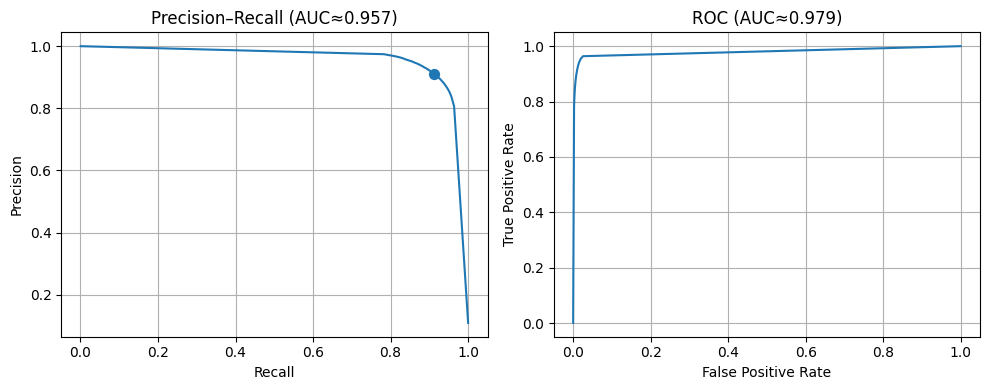

In [ ]:
# CELL — PR / ROC curves + AUC, and best-F1 threshold (fast, vectorized)

import numpy as np
import matplotlib.pyplot as plt

probs = _flatten01(preds_np)  # shape (N, P)
gts   = _flatten01(gts_np)

# thresholds for curves
ths = np.linspace(0.0, 1.0, 101)
prec_list, rec_list, tpr_list, fpr_list, f1_list = [], [], [], [], []

for t in ths:
    p = (probs >= t).astype(np.float32)
    tp = (p * gts).sum(axis=1)
    fp = (p * (1 - gts)).sum(axis=1)
    fn = ((1 - p) * gts).sum(axis=1)
    tn = ((1 - p) * (1 - gts)).sum(axis=1)

    prec, rec, f1, acc, spec, iou, dice = metrics_from_conf(tp, fp, fn, tn)
    # mean over images for the curve
    prec_list.append(prec.mean())
    rec_list.append(rec.mean())
    tpr_list.append(rec.mean())             # TPR = recall
    fpr_list.append((fp.mean()) / (fp.mean() + tn.mean() + 1e-7))
    f1_list.append(f1.mean())

# best-F1 threshold
best_idx = int(np.argmax(f1_list))
best_t = float(ths[best_idx])
print(f"Best-F1 threshold: {best_t:.3f}, F1={f1_list[best_idx]:.4f}, Precision={prec_list[best_idx]:.4f}, Recall={rec_list[best_idx]:.4f}")

# simple AUC estimates (trapezoidal)
def trapz_auc(x, y):
    order = np.argsort(x)
    return float(np.trapz(np.array(y)[order], np.array(x)[order]))

pr_auc  = trapz_auc(rec_list, prec_list)    # area under PR (approx)
roc_auc = trapz_auc(fpr_list, tpr_list)     # area under ROC (approx)

print(f"PR-AUC  ≈ {pr_auc:.4f}")
print(f"ROC-AUC ≈ {roc_auc:.4f}")

# plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rec_list, prec_list)
plt.scatter(rec_list[best_idx], prec_list[best_idx], s=50)
plt.title(f"Precision–Recall (AUC≈{pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fpr_list, tpr_list)
plt.title(f"ROC (AUC≈{roc_auc:.3f})")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3670492237.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.subplot(2,3,4); plt.boxplot([dice,iou,prec,rec], labels=["Dice","IoU","Prec","Rec"]); plt.title("Boxplots")


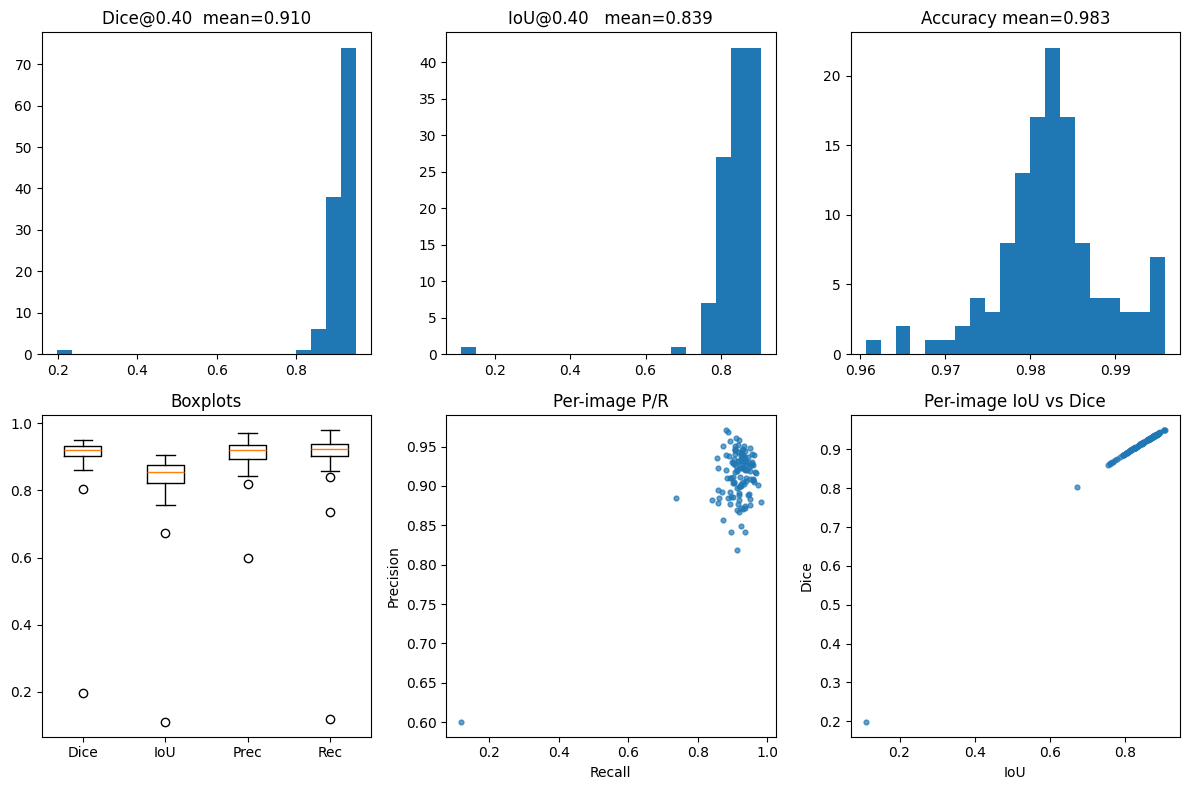

In [ ]:
import numpy as np, matplotlib.pyplot as plt

probs = _flatten01(preds_np)
gts   = _flatten01(gts_np)
pred  = (probs >= TH).astype(np.float32)

tp = (pred * gts).sum(1); fp = (pred * (1-gts)).sum(1); fn = ((1-pred)*gts).sum(1); tn = ((1-pred)*(1-gts)).sum(1)
eps = 1e-7
prec = (tp+eps)/(tp+fp+eps)
rec  = (tp+eps)/(tp+fn+eps)
iou  = (tp+eps)/(tp+fp+fn+eps)
dice = (2*tp+eps)/(2*tp+fp+fn+eps)
acc  = (tp+tn+eps)/(tp+tn+fp+fn+eps)

plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.hist(dice, bins=20); plt.title(f"Dice@{TH:.2f}  mean={dice.mean():.3f}")
plt.subplot(2,3,2); plt.hist(iou,  bins=20); plt.title(f"IoU@{TH:.2f}   mean={iou.mean():.3f}")
plt.subplot(2,3,3); plt.hist(acc,  bins=20); plt.title(f"Accuracy mean={acc.mean():.3f}")
plt.subplot(2,3,4); plt.boxplot([dice,iou,prec,rec], labels=["Dice","IoU","Prec","Rec"]); plt.title("Boxplots")
plt.subplot(2,3,5); plt.scatter(rec, prec, s=12, alpha=0.7); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Per-image P/R")
plt.subplot(2,3,6); plt.scatter(iou, dice, s=12, alpha=0.7); plt.xlabel("IoU"); plt.ylabel("Dice"); plt.title("Per-image IoU vs Dice")
plt.tight_layout(); plt.show()


In [ ]:
import os, numpy as np, tensorflow as tf, imageio, zipfile, matplotlib.pyplot as plt

THRESH = 0.40          # <- use your best threshold
MAX_SAMPLES = 48       # how many val images to export
OUT_DIR = "/content/gt_pred_samples"
os.makedirs(OUT_DIR, exist_ok=True)

saved = []
count = 0
for batch_imgs, batch_gts in val_ds:
    preds = G.predict(batch_imgs, verbose=0)
    for i in range(batch_imgs.shape[0]):
        if count >= MAX_SAMPLES: break
        img = (tf.squeeze(batch_imgs[i]).numpy()*255).astype(np.uint8)
        gt  = (tf.squeeze(batch_gts[i]).numpy()*255).astype(np.uint8)
        prb = tf.squeeze(preds[i]).numpy()
        pr  = (prb >= THRESH).astype(np.uint8)*255

        # file bases
        base = f"{count:03d}"
        img_path = os.path.join(OUT_DIR, f"{base}_image.png")
        gt_path  = os.path.join(OUT_DIR, f"{base}_gt.png")
        pr_path  = os.path.join(OUT_DIR, f"{base}_pred.png")
        comp_path= os.path.join(OUT_DIR, f"{base}_image_gt_pred.png")

        # save individual images
        imageio.v3.imwrite(img_path, img)
        imageio.v3.imwrite(gt_path,  gt)
        imageio.v3.imwrite(pr_path,  pr)

        # save composite (image | GT | Pred)
        comp = np.concatenate([img, gt, pr], axis=1)
        imageio.v3.imwrite(comp_path, comp)

        saved += [img_path, gt_path, pr_path, comp_path]
        count += 1
    if count >= MAX_SAMPLES: break

# zip them for easy download
ZIP_PATH = "/content/gt_pred_samples.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for p in saved:
        z.write(p, arcname=os.path.basename(p))

print(f"Saved {count} samples to {OUT_DIR}")
print("ZIP:", ZIP_PATH)


Saved 48 samples to /content/gt_pred_samples
ZIP: /content/gt_pred_samples.zip


In [ ]:
# GT vs Pred panels (binary or multi-class) — Colab-ready

import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, imageio, zipfile
from matplotlib.colors import ListedColormap

# ---- settings ----
THRESH = float(BEST["threshold"]) if "BEST" in globals() and "threshold" in BEST else 0.40
MAX_FIGS = 24                  # how many figures to produce
OUT_DIR = "/content/gt_vs_pred_figs"
os.makedirs(OUT_DIR, exist_ok=True)

def to_u8_gray(x):
    x = np.squeeze(x)
    if x.max() <= 1.0: x = x * 255.0
    return x.astype(np.uint8)

def pred_to_label(pred):
    """Returns integer labels: binary via threshold or argmax if multi-class."""
    p = np.squeeze(pred)
    if p.ndim == 2:     # already single-channel map
        return (p >= THRESH).astype(np.int32)
    if p.ndim == 3 and p.shape[-1] == 1:
        return (p[..., 0] >= THRESH).astype(np.int32)
    # multi-class (softmax channels)
    return np.argmax(p, axis=-1).astype(np.int32)

def mask_to_label(mask):
    m = np.squeeze(mask)
    if m.dtype != np.int32 and m.dtype != np.int64:
        # binary GT stored as 0/1 floats
        return (m > 0.5).astype(np.int32)
    return m.astype(np.int32)

def choose_cmap(n_classes):
    if n_classes <= 2:
        return ListedColormap(['#1f1f7a', '#ffcc00'])  # background, foreground
    # a few pleasant distinct colors for multi-class
    return plt.get_cmap('tab20', n_classes)

# ---- loop over val set and make panels ----
made = 0
for imgs, gts in val_ds:
    preds = G.predict(imgs, verbose=0)
    b = imgs.shape[0]
    for i in range(b):
        if made >= MAX_FIGS: break

        img = np.squeeze(imgs[i])
        gt_lab = mask_to_label(gts[i])
        pr_lab = pred_to_label(preds[i])

        n_classes = int(max(gt_lab.max(), pr_lab.max())) + 1
        cmap = choose_cmap(n_classes)

        # figure like your reference: 1x2 (GT, Pred)
        fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
        ax[0].imshow(gt_lab, cmap=cmap, vmin=0, vmax=n_classes-1)
        ax[0].set_title("Ground Truth Segmentation"); ax[0].axis('off')

        ax[1].imshow(pr_lab, cmap=cmap, vmin=0, vmax=n_classes-1)
        ax[1].set_title("Predicted Segmentation"); ax[1].axis('off')

        # optional: outline GT on top of Pred to see errors
        try:
            ax[1].contour(gt_lab, colors='white', linewidths=0.6)
        except Exception:
            pass

        out_path = os.path.join(OUT_DIR, f"gt_vs_pred_{made:04d}.png")
        fig.savefig(out_path, dpi=140)
        plt.close(fig)

        made += 1
    if made >= MAX_FIGS: break

# also export a quick montage grid (8 panels) into one image
if made > 0:
    import math, PIL.Image as Image
    k = min(8, made)
    thumbs = [Image.open(os.path.join(OUT_DIR, f)) for f in sorted(os.listdir(OUT_DIR))[:k]]
    w, h = thumbs[0].size
    cols, rows = 4, math.ceil(k/4)
    canvas = Image.new("RGB", (cols*w, rows*h), "white")
    for idx, im in enumerate(thumbs):
        r, c = divmod(idx, cols)
        canvas.paste(im, (c*w, r*h))
    montage_path = os.path.join(OUT_DIR, "montage.png")
    canvas.save(montage_path)
    print("Montage:", montage_path)

# zip for download
ZIP = os.path.join(OUT_DIR, "gt_vs_pred_panels.zip")
with zipfile.ZipFile(ZIP, "w", zipfile.ZIP_DEFLATED) as z:
    for f in sorted(os.listdir(OUT_DIR)):
        if f.endswith(".png"):
            z.write(os.path.join(OUT_DIR, f), arcname=f)

print(f"Saved {made} panel(s) to {OUT_DIR}")
print("Zip:", ZIP)


Montage: /content/gt_vs_pred_figs/montage.png
Saved 24 panel(s) to /content/gt_vs_pred_figs
Zip: /content/gt_vs_pred_figs/gt_vs_pred_panels.zip


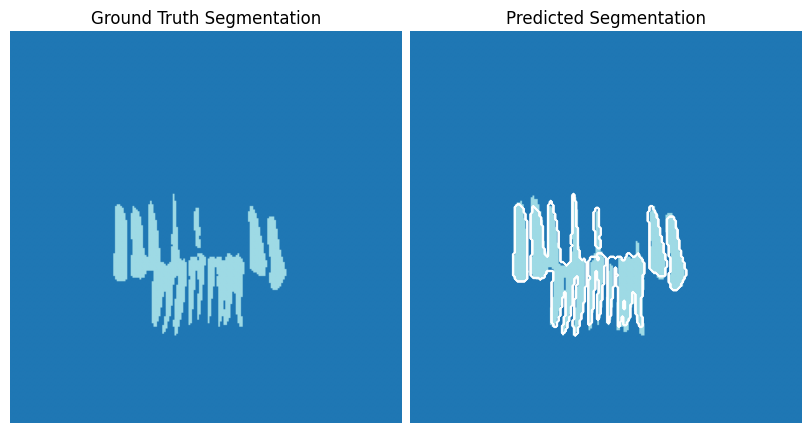

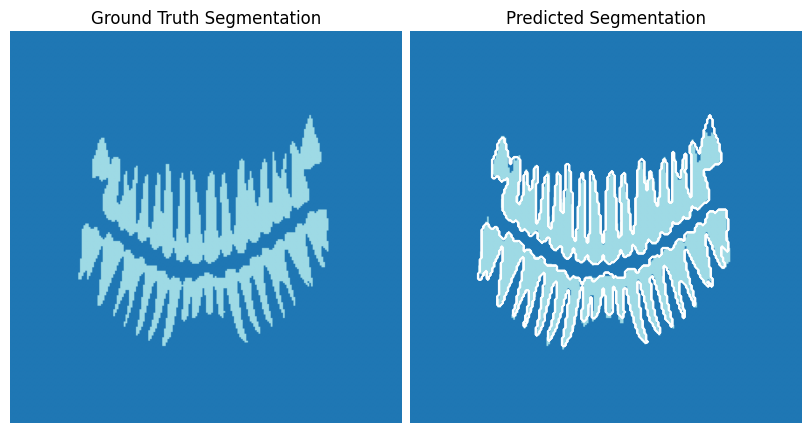

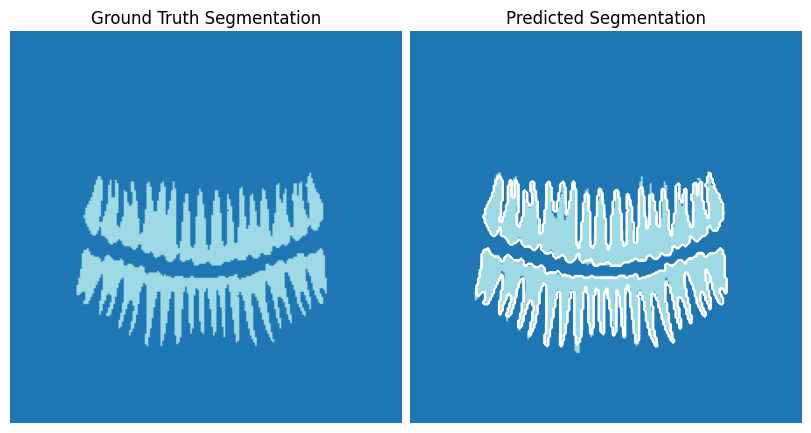

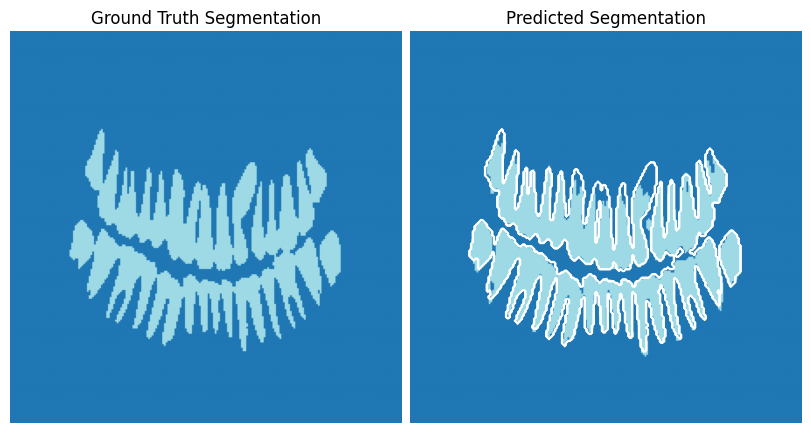

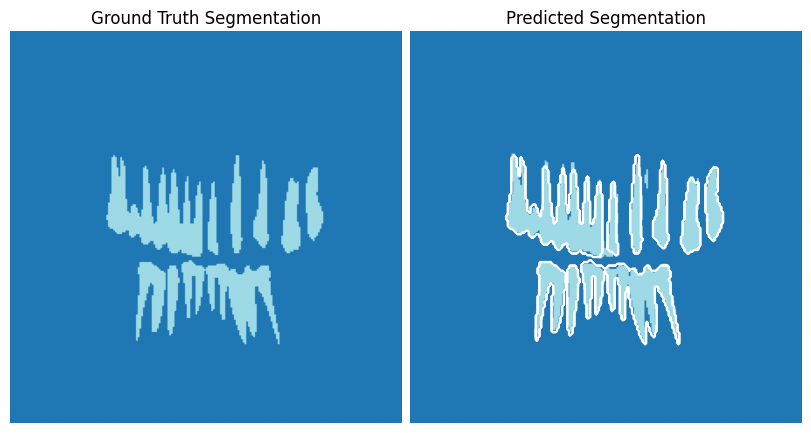

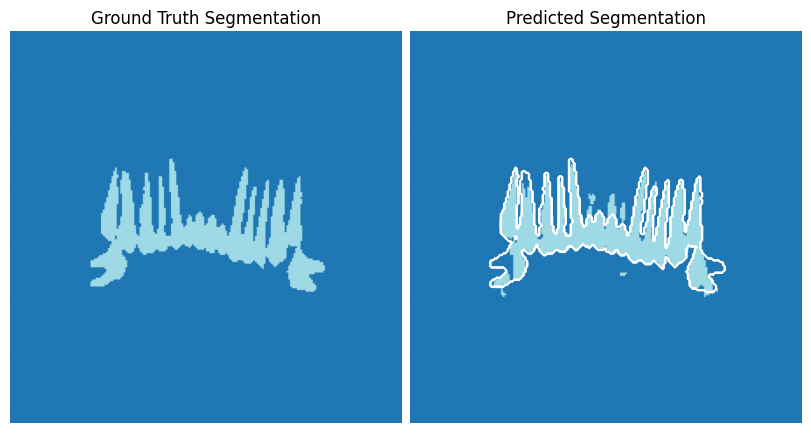

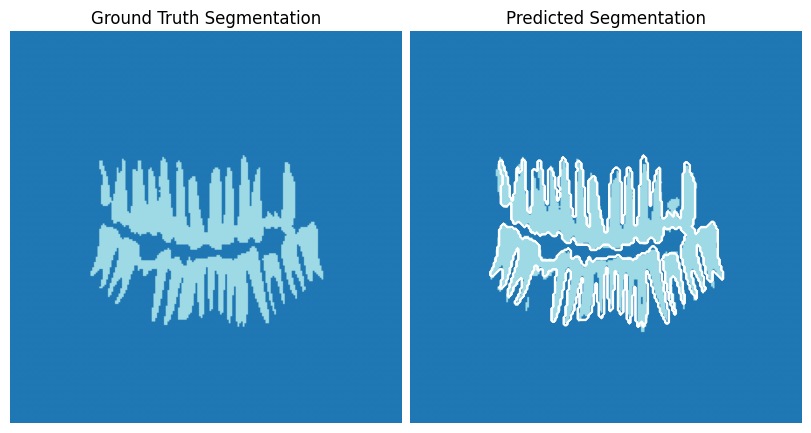

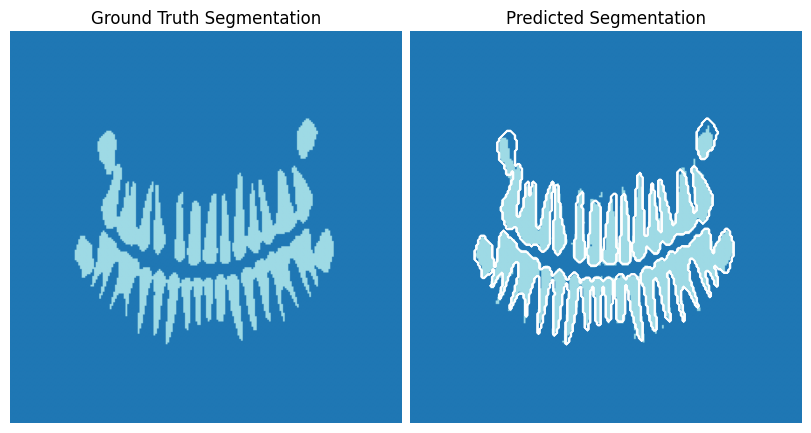

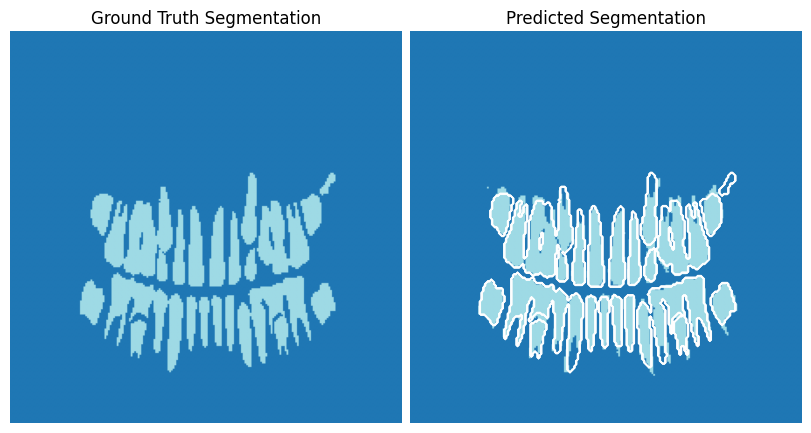

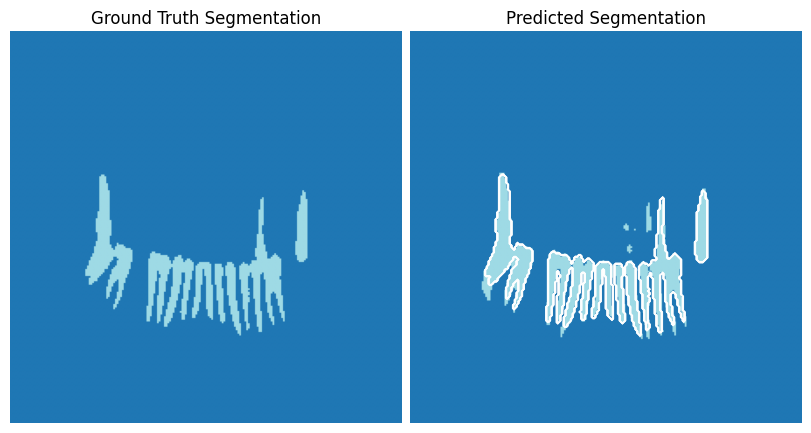

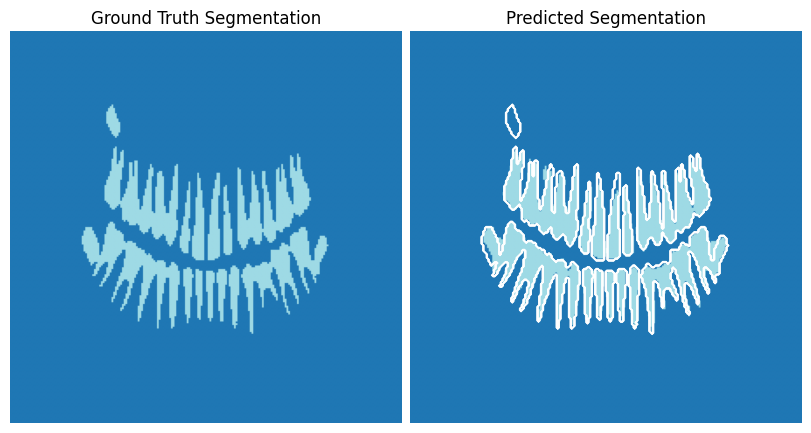

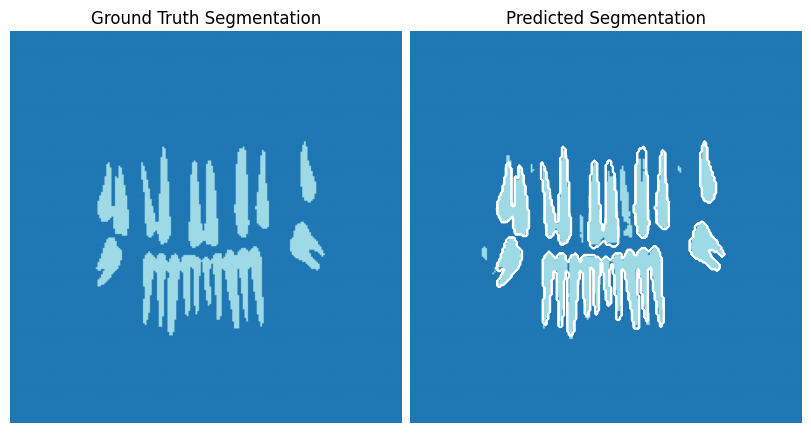

Created 12 panels in /content/gt_vs_pred_figs


In [ ]:
# Rebuild per-image GT vs Pred panels and show a few inline
import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, imageio

THRESH = float(BEST["threshold"]) if "BEST" in globals() and "threshold" in BEST else 0.40
MAX_FIGS = 12
OUT_DIR = "/content/gt_vs_pred_figs"
os.makedirs(OUT_DIR, exist_ok=True)

def pred_to_label(pred):
    p = np.squeeze(pred)
    if p.ndim == 2 or (p.ndim == 3 and p.shape[-1] == 1):
        return (p[..., 0] if p.ndim == 3 else p) >= THRESH
    return np.argmax(p, axis=-1)

def mask_to_label(mask):
    m = np.squeeze(mask)
    if m.dtype.kind in "ui":  # already labels
        return m
    return (m > 0.5).astype(np.int32)

made = 0
for imgs, gts in val_ds:
    preds = G.predict(imgs, verbose=0)
    b = imgs.shape[0]
    for i in range(b):
        if made >= MAX_FIGS: break
        gt_lab = mask_to_label(gts[i])
        pr_lab = pred_to_label(preds[i]).astype(np.int32)

        fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
        ax[0].imshow(gt_lab, cmap='tab20', vmin=0, vmax=max(gt_lab.max(), pr_lab.max()))
        ax[0].set_title("Ground Truth Segmentation"); ax[0].axis('off')
        ax[1].imshow(pr_lab, cmap='tab20', vmin=0, vmax=max(gt_lab.max(), pr_lab.max()))
        ax[1].contour(gt_lab, colors='white', linewidths=0.6)
        ax[1].set_title("Predicted Segmentation"); ax[1].axis('off')
        path = os.path.join(OUT_DIR, f"gt_vs_pred_{made:04d}.png")
        fig.savefig(path, dpi=140)
        plt.show()
        made += 1
    if made >= MAX_FIGS: break

print(f"Created {made} panels in {OUT_DIR}")
